ADD COLAB BADGE (kida) 

In [ ]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bwandowando/ukraine-russian-crisis-twitter-dataset-1-2-m-rows
!unzip ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip -d dataset
!rm ukraine-russian-crisis-twitter-dataset-1-2-m-rows.zip

In [2]:
import csv
import hashlib
import os
import pathlib
import pickle
import random
import re
import string
import timeit
import unicodedata
from collections import defaultdict
from itertools import combinations
from typing import Callable, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn.functional as F
from scipy.optimize import fsolve
from scipy.stats import kendalltau, spearmanr
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel

In [3]:
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', exclude=['parser', 'ner'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Implementation

## Hash utils

In [4]:
def is_prime(n: int) -> bool:
    if n < 2:
        return False
    for i in range(2, int(np.sqrt(n))+1):
        if (n % i) == 0:
            return False
    return True

def find_closest_prime(n: int) -> int:
    """Finds the closest prime number higher than input."""
    while True:
        if is_prime(n):
            return n
        n += 1

def get_variable_length_hash(
    n_bits: int
) -> Callable[[str], int]:
    """Generates a hash function that takes a string
    as input and has 2 ** n_bits integer buckets.
    """
    def inner_f(s: str) -> int:
        binary_str = bin(
            int.from_bytes(
                hashlib.sha256(s.encode()).digest(), 
                'little'
            )
        )[-n_bits:]
        return int(binary_str, 2)
    return inner_f

class HashGenerator:
    """Generator of hash functions of the form:
            h(x) = (ax + b) mod c
    where x is a row number, a and b are random numbers
    smaller than the maximum row number and c is a prime
    number higher than the maximum row number.

    Note that a and b must be unique for a given signature
    matrix.

    This approach to hash function generation was suggested
    in [1].

    Parameters
    ----------
    num_rows : int
        Maximum number of rows of the characteristic matrix.

    References
    ----------
        [1] http://ethen8181.github.io/machine-learning/clustering_old/text_similarity/text_similarity.html

    """
    def __init__(
        self, 
        num_rows: int, 
    ) -> None:
        self.num_rows = num_rows
        self.prime = find_closest_prime(num_rows)
        self.a_set = set()
        self.b_set = set()

    def get_num_rows(self) -> int:
        return self.num_rows

    def next(self) -> Callable[[np.uint32], np.uint32]:
        """Returns a hash function that takes a row number 
        as input and returns another row number as output.
        """
        a = self._generate_coeff(self.a_set, self.num_rows)
        b = self._generate_coeff(self.b_set, self.num_rows)
        return lambda row: np.uint32((a * row + b) % self.prime)

    def _generate_coeff(
        self, 
        coeff_set: set[int],
        max_val: int
    ) -> int:
        while True:
            coeff = random.randint(1, max_val)
            if coeff not in coeff_set:
                coeff_set.add(coeff)
                return coeff

## Preprocessing utils

In [263]:
def normalize_white_space(doc: str) -> str:
    return " ".join(doc.split())

def remove_https(doc: str) -> str:
    return re.sub(r'https?://[^ ]+', '', doc)

def replace_chars(doc: str) -> str:
    return doc.replace('&amp;', ' and ')

def remove_non_ascii(doc: str) -> str:
    """Removes non ascii and non printable characters.
    We keep cyrillic characters due to the nature
    of the dataset.
    """
    cyr_chars = "АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя"

    res = ""
    for c in doc:
        if (c.isascii() and c.isprintable()) \
            or (c in cyr_chars) or c.isspace():
            res += c
    return res

def strip_accents(doc: str) -> str:
    """Replaces words with accent with their 
    counterpart without accent. This also deals with 
    special characters such as 𝕒, 𝕕, 𝕖, 𝙖, 𝙘, 𝙙. 
    """
    return unicodedata.normalize('NFKD', doc)

def strip_punctuation(doc: str) -> str:
    return re.sub('[' + re.escape(string.punctuation) + ']', '', doc)
    
def get_lemmatizer( 
    nlp: spacy.pipeline, 
    allow_stop_words: bool = False,
    allow_punct: bool = False,
    allow_numbers: bool = False
) -> Callable[[str], str]:
    """Generates a function that takes a string as
    input and returns the string sequence of lemmas
    in the input string. Optionally, the generated
    function removes stop words, punctuation and
    numbers.

    Note that numbers are tokens identified as such.
    For instance, '62,000' is a number, but 'T-72' is
    not.

    Parameters
    ----------
    nlp : spacy.pipeline
        Spacy object that carries out the lemmatization.
    
    allow_stop_words : bool
        Boolean value to filter or allow stop words.

    allow_punct : bool
        Boolean value to filter or allow punctuation.
    
    allow_numbers : bool
        Boolean value to filter or allow numbers.

    Returns
    -------
    The generated function. 
    """
    def inner_f(doc: str) -> str:
        return ' '.join(
            [
                token.lemma_
                for token in nlp(doc)
                if (not token.is_stop or allow_stop_words) \
                    and (not token.is_punct or allow_punct) \
                    and (token.pos_ != 'NUM' or allow_numbers) \
                    and (not token.pos_ == 'X')
            ]
        )
    return inner_f

## Model

In [36]:
def jaccard_similarity(
    x: np.ndarray, 
    y: np.ndarray
) -> float:
    numerator = len(set(x).intersection(set(y)))
    denominator = len(set(x).union(set(y)))
    return numerator / denominator

class LSHModel:
    """Implementation of LSH model that finds similar pairs
    of documents encoded as k-gram shingles.

    Parameters
    ----------
    k : int
        Number of characters in each k-gram.

    threshold : float
        The similarity value required to consider a
        pair as similar.

    num_hashes : int
        Number of hash functions used to generate the
        signature matrix.

    shingle_hash_bits : int
        Determines the number of buckets of the hash
        function that maps each shingle to an integer.

    track_shingles : bool
        Flag to keep track of the number of different
        shingles found in the corpus, as well as the
        number of different characters in the shingles.

    checkpoint_path : Optional[str]
        Path to save and load the state of the model.

    Exceptions
    ----------
    ValueError
        If the number of hash functions is higher than the
        number of rows of the characteristic matrix (which is
        also the number of shingles). This is due to the fact
        that the the coefficients 'a' and 'b' of the hash
        functions generated by HashGenerator need to be unique
        within the given signature matrix.
    """
    def __init__(
        self,
        k: int,
        threshold: float,
        num_hashes: int,
        shingle_hash_bits: int,
        track_shingles: bool = False,
        checkpoint_path: Optional[str] = None
    ) -> None:
        self.k = k
        self.threshold = threshold
        self.num_hashes = num_hashes
        self.shingle_set = set()
        self.char_set = set()
        self.shingle_hash_bits = shingle_hash_bits
        self.shingle_hash = get_variable_length_hash(
            shingle_hash_bits
        )
        self.num_shingles = 2 ** shingle_hash_bits
        self.track_shingles = track_shingles
        self.checkpoint_path = checkpoint_path
        self.num_docs = 0
        self.docs_dict = dict()
        self.signature = None
        self.candidate_pairs = set()
        self.fp_pairs = set()
        self.similar_pairs = set()
        self.b = -1
        self.r = -1
        self.sig_idx = -1

        if self.num_hashes > self.num_shingles:
            raise ValueError(
                f"Number of hash functions must be lower than "
                f"or equal to the number of shingles. Found "
                f"{self.num_hashes} hash functions and "
                f"{self.num_shingles} shingles."
            )

    def load_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', 'docs_dict'),
                (f'{self.checkpoint_path}/shingle_set.npy', 'shingle_set'),
                (f'{self.checkpoint_path}/char_set.npy', 'char_set'),
                (f'{self.checkpoint_path}/signature.npy', 'signature'),
                (f'{self.checkpoint_path}/sig_idx.npy', 'sig_idx'),
                (f'{self.checkpoint_path}/candidate_pairs.npy', 'candidate_pairs'),
                (f'{self.checkpoint_path}/fp_pairs.npy', 'fp_pairs'),
                (f'{self.checkpoint_path}/similar_pairs.npy', 'similar_pairs')
            ]

            for file_path, attr in tup_ls:
                if os.path.isfile(file_path):
                    if attr in ['signature']:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True)
                        )
                    else:
                        setattr(
                            self, 
                            attr, 
                            np.load(file_path, allow_pickle=True).item()
                        )
                        
    def save_checkpoint(
        self,
        checkpoint_path: Optional[str] = None
    ) -> None:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is None:
            raise ValueError(
                "Checkpoint path not found"
            )
        else:
            os.makedirs(self.checkpoint_path, exist_ok=True)

            tup_ls = [
                (f'{self.checkpoint_path}/docs_dict.npy', self.docs_dict),
                (f'{self.checkpoint_path}/shingle_set.npy', self.shingle_set),
                (f'{self.checkpoint_path}/char_set.npy', self.char_set),
                (f'{self.checkpoint_path}/signature.npy', self.signature),
                (f'{self.checkpoint_path}/sig_idx.npy', self.sig_idx),
                (f'{self.checkpoint_path}/candidate_pairs.npy', self.candidate_pairs),
                (f'{self.checkpoint_path}/fp_pairs.npy', self.fp_pairs),
                (f'{self.checkpoint_path}/similar_pairs.npy', self.similar_pairs)
            ]

            for file_path, val in tup_ls:
                np.save(file_path, val)

    def add_document(
        self, 
        doc: str,
        preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None
    ) -> None:
        """Creates shingles from the document given in input and
        adds those shingles to the model. Optionally, the document
        is preprocessed with a number of functions given in a 
        pipeline.

        Parameters
        ----------
        doc : str
            String document to be processed.

        preprocessing_pipeline : Optional[list[Callable[[str], str]]]
            List of functions that take a string and return a string.
            This is used to filter stop words, apply lemmatization, etc.
        """
        if preprocessing_pipeline is not None:
            for f in preprocessing_pipeline:
                doc = f(doc)
        shingles = self._create_shingles(
            doc, 
            self.k,
            self.track_shingles,
            self.shingle_hash
        )
        self.docs_dict[self.num_docs] = shingles
        self.num_docs += 1

    def get_similar_pairs(
        self,
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> set[tuple[tuple[int, int], float]]:
        """Returns the pairs having an approximated similarity 
        higher than a fixed threshold. The pairs are provided as 
        a set of tuples containing the indices of the documents and
        their similarity value. 
        
        The approximated similarity measure is the Jaccard
        similarity.

        This function also saves the false positive pairs identified
        after double-checking the signature matrix.

        Parameters
        ----------
        checkpoint_path : Optional[str]
            Path to save and load the state of the model. This is used
            when building the signature matrix.

        checkpoint_freq : int
            Frequency with which the state of the model is saved.
        
        Returns
        -------
        The set of pairs approximately similar, alongside their 
        similarity value.
        """
        hg = HashGenerator(self.num_shingles)
        hash_functions = [
            hg.next()
            for _ in range(self.num_hashes)
        ]
        self.signature = self._build_signature(
            self.docs_dict,
            self.num_shingles,
            hash_functions,
            checkpoint_path,
            checkpoint_freq
        )
        self.b, self.r = self._find_lsh_params(
            self.threshold,
            self.num_hashes
        )
        self.candidate_pairs = self._lsh(
            self.signature,
            self.b
        )
        self.similar_pairs, self.fp_pairs = \
            self._check_threshold_on_signature(
                self.candidate_pairs,
                self.signature,
                self.threshold
            )
        return self.similar_pairs

    def _create_shingles(
        self,
        doc: str, 
        k: int,
        track_shingles: bool, 
        hash_f: Callable[[str], int]
    ) -> np.ndarray:
        res = []

        for i in range(len(doc[:-k+1])):
            shingle = doc[i:i+k]
            if track_shingles:
                self.shingle_set.add(shingle)
                self.char_set = self.char_set.union(
                    set(shingle)
                ) 
            res.append(hash_f(shingle))

        return np.unique(res).astype(np.uint32)

    def _build_signature(
        self,
        docs_dict: dict[int, np.ndarray],
        num_rows: int, 
        hash_functions: list[Callable[[np.uint32], np.uint32]],
        checkpoint_path: Optional[str] = None,
        checkpoint_freq: int = 10000
    ) -> np.ndarray:
        if checkpoint_path is not None:
            self.checkpoint_path = checkpoint_path
        if self.checkpoint_path is not None:
            os.makedirs(self.checkpoint_path, exist_ok=True)
        
        sig_path = f'{self.checkpoint_path}/temp_signature.npy'
        sig_idx_path = f'{self.checkpoint_path}/temp_sig_idx.npy'
        
        if self.checkpoint_path is not None and \
            os.path.isfile(sig_path) and \
            os.path.isfile(sig_idx_path):
                signature = np.load(sig_path, allow_pickle=True)
                self.sig_idx = np.load(
                    sig_idx_path, 
                    allow_pickle=True
                ).item()
                print(f"Loaded signature from row {self.sig_idx}")
        else:
            signature = np.full(
                (len(hash_functions), len(docs_dict)), 
                fill_value=np.inf
            )
            self.sig_idx = -1

        for r in tqdm(
            range(0, num_rows),
            total=num_rows,
            desc='[Signature matrix] row number',
            leave=False
        ):
            if r < self.sig_idx:
                continue

            hash_values = [
                f(r)
                for f in hash_functions
            ]
            for c, shingles in enumerate(docs_dict.values()):
                if r in shingles:
                    for i, hash_val in enumerate(hash_values):
                        if hash_val < signature[i,c]:
                            signature[i,c] = hash_val

            self.sig_idx = r
            if (self.sig_idx % checkpoint_freq == 0) and \
                self.checkpoint_path is not None:
                np.save(sig_path, signature)
                np.save(sig_idx_path, self.sig_idx)

        if self.checkpoint_path is not None:
            np.save(sig_path, signature)
            np.save(sig_idx_path, self.sig_idx)
        
        return signature.astype(np.uint32)

    def _find_lsh_params(self, t: int, n: int) -> tuple[int]:
        """Note that a lower b means that two items must match 
        a higher number of rows. By taking the floor of b, we 
        favor more similar pairs.
        """
        def equations(vars):
            b, r = vars
            eq1 = t - (1 / b) ** (1 / r)
            eq2 = n - b * r
            return [eq1, eq2]

        b, r =  fsolve(equations, (1, 1))
        b = np.floor(b)
        r = n // b
        return int(b), int(r)

    def _lsh(
        self, 
        signature: np.ndarray, 
        b: int
    ) -> set[tuple[int, int]]:
        candidate_pairs = set()
        
        for band in np.array_split(signature, b):
            
            # column tuple -> list of column indices having that tuple
            same_columns = defaultdict(list) 
            
            for c in range(band.shape[1]):
                column = band[:,c]
                same_columns[tuple(column)].append(c)

            filtered_same_columns = dict()
            for k, values in same_columns.items():
                if len(values) >= 2:
                    filtered_same_columns[k] = values

            for values in filtered_same_columns.values():
                for pair in combinations(values, 2):
                    candidate_pairs.add(pair)

        return candidate_pairs

    def _check_threshold_on_signature(
        self, 
        candidate_pairs: list[tuple[int, int]], 
        signature: np.ndarray, 
        t: float
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in candidate_pairs:
            x_col = signature[:,x]
            y_col = signature[:,y]
            similarity = sum(x_col == y_col) / signature.shape[0]
            tup = ((x, y), similarity)
            if similarity >= t:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def check_threshold_on_cm(
        self
    ) -> tuple[set[tuple[tuple[int, int], float]]]:
        """Returns two sets of pairs. The first is the set
        of similar pairs obtained after checking the candidate
        pairs returned by the LSH procedure (before the double-check
        on the signature matrix) against the actual Jaccard
        similarity computed from the characteristic matrix.

        The second is the set of false positive pairs identified
        after the double-check against the characteristic matrix.
        """
        similar_pairs = set()
        false_positive_pairs = set()

        for (x, y) in self.candidate_pairs:
            similarity = jaccard_similarity(
                self.docs_dict[x], 
                self.docs_dict[y]
            )
            tup = ((x, y), similarity)
            if similarity >= self.threshold:
                similar_pairs.add(tup)
            else:
                false_positive_pairs.add(tup)

        return similar_pairs, false_positive_pairs

    def get_shingle_set(self) -> set[int]:
        return self.shingle_set

    def get_char_set(self) -> set[str]:
        return self.char_set

    def get_docs_dict(self) -> dict[int, np.ndarray]:
        return self.docs_dict

## General utils

In [273]:
def mean_absolute_error(
    x: list, 
    y: list
) -> float:
    return sum(
        [np.abs(val2 - val1) for val1, val2 in zip(x, y)]
    ) / len(x)

def evaluate_on_cm(
    sig_dict: dict[tuple[int, int], float], 
    cm_dict: dict[tuple[int, int], float]
) -> tuple[int, float]:
    """Evaluates the model performance by computing
    the number of false positive pairs and the
    mean absolute error (MAE) against the characteristic
    matrix.

    Parameters
    ----------
    sig_dict : dict[tuple[int, int], float]
        Dictionary that maps each similar pair to the
        corresponding similarity value obtained as
        estimation from the signature matrix.

    cm_dict : dict[tuple[int, int], float]
        Dictionary that maps each similar pair to the
        corresponding similarity value obtained by
        computing the Jaccard similarity on the 
        characteristic matrix.
    
    Returns
    -------
    The number of false positive pairs and the MAE.
    """
    common = set(sig_dict).intersection(set(cm_dict))
    num_wrong = len(sig_dict) - len(common)

    sig_values = []
    cm_values = []

    for pair in common:
        sig_values.append(sig_dict[pair])
        cm_values.append(cm_dict[pair])

    return num_wrong, \
        mean_absolute_error(sig_values, cm_values) 

def train_model(
    model: LSHModel, 
    data_path: str, 
    num_docs: int,
    verbose: bool = False,
    filtering_pipeline: Optional[list[Callable[[str], str]]] = None, 
    preprocessing_pipeline: Optional[list[Callable[[str], str]]] = None  
) -> LSHModel:
    """Trains the model on a given number of documents
    taken from a provided dataset. Training here means
    adding the shingles of the documents to the model.

    Parameters
    ----------
    model : LSHModel
        The model to be trained.

    data_path : str
        The path where the files of the dataset are
        stored.

    num_docs : int
        The number of documents on which the model
        will be trained.

    verbose : bool
        Flag that determines whether to print 
        information about the processing.

    filtering_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used on the text field of the dataframe, before
        feeding the data to the model.

    preprocessing_pipeline : Optional[list[Callable[[str], str]]]
        List of functions that take a string and return a string.
        This is used to preprocess documents being added to 
        the model.
    
    Returns
    -------
    The trained model.
    """
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    duplicates = 0
    count = num_docs

    with tqdm(
        total=num_docs,
        desc='Adding documents to model',
        leave=False
    ) as pbar:
        for file in files:
            if count == 0:
                break

            if verbose:
                print(f'Reading file {file}')
            df = pd.read_csv(
                file, 
                compression='gzip', 
                index_col=0,
                encoding='utf-8', 
                quoting=csv.QUOTE_ALL,
                low_memory=False
            )

            df = df[df['language'] == 'en']

            if filtering_pipeline is not None:
                for filter_f in filtering_pipeline:
                    df['text'] = df['text'].apply(filter_f)

            df_unique = df.drop_duplicates(subset=['text'])
            duplicates += len(df) - len(df_unique)

            for index, row in tqdm(
                df_unique.iterrows(),
                total=len(df_unique),
                desc='Reading file',
                leave=False
            ):
                text = row['text']
                model.add_document(
                    text,
                    preprocessing_pipeline
                )
                
                count -= 1
                pbar.update(1)
                if count == 0:
                    break

    if verbose:       
        print(f'Found {duplicates} duplicates in files')

    return model

def get_text(
    idx_ls: list[int], 
    data_path: str
) -> list[tuple[int, str]]:
    """Returns a list containing the original texts
    from the dataset (before the preprocessing) alongside
    their indices.

    Parameters
    ----------
    idx_ls : list[int]
        The list of the indices of the documents to 
        be retrieved.

    data_path : str
        The path where the files of the dataset are
        stored.
    
    Returns
    -------
    Tuples containing the indices of the documents and their
    original text.
    """
    max_idx = max(idx_ls)
    result = []
    
    files = []

    for name in os.listdir(data_path):
        full_path = os.path.join(data_path, name)
        if os.path.isfile(full_path):
            files.append(full_path)

    count = 0

    for file in files:
        df = pd.read_csv(
            file, 
            compression='gzip', 
            index_col=0,
            encoding='utf-8', 
            quoting=csv.QUOTE_ALL,
            low_memory=False
        )

        df = df[df['language'] == 'en']
        df_unique = df.drop_duplicates(subset=['text'])

        for index, row in df_unique.iterrows():
            if count in idx_ls:
                result.append((count, row['text']))
            if count == max_idx:
                return result
            count += 1

def mean_pooling(
    model_output: torch.Tensor, 
    attn_mask: torch.Tensor
) -> torch.Tensor:
    """Returns the mean of the embeddings taken from 
    the last layer of the model, in order to give 
    a single embedding for each document. The mean
    is weighted with the attention mask, so that 
    the padding and control tokens added by the model
    are not considered in the mean.

    Parameters
    ----------
    model_output : torch.Tensor
        Embeddings for all the documents.

    attn_mask : torch.Tensor
        The attention mask of the model for all the
        documents.
    
    Returns
    -------
    The weighted mean embedding for each document. 
    """
    token_embeddings = model_output['last_hidden_state']

    # attn_mask shape: [13, 512] -> [13, 512, 768]
    expanded_attn_mask = attn_mask.unsqueeze(-1).expand_as(token_embeddings)

    # * or torch.mul: out_i = input_i x other_i 
    # might use torch.clamp to avoid dividing by 0
    return torch.sum(
        token_embeddings * expanded_attn_mask, 1
    ) / expanded_attn_mask.sum(1)

def torch_cosine_similarity(x, y):
    return torch.matmul(
        F.normalize(x, dim=-1), 
        F.normalize(y, dim=-1)
    )

# Experiments

In [278]:
if os.path.isdir(r'e:\datasets\ukraine'):
    DATA_PATH = r'e:\datasets\ukraine'
else:
    DATA_PATH = os.path.join(os.getcwd(), 'dataset')

os.makedirs('img', exist_ok=True)

In [279]:
filtering_pipeline = [
    remove_https
]

preprocessing_pipeline = [
    strip_accents,
    replace_chars,
    get_lemmatizer(
        nlp,
        allow_numbers=True
    ),
    str.lower,
    strip_punctuation,
    remove_non_ascii,
    normalize_white_space
]

## Shingle and character number growth

In [280]:
results = dict()

for k in [4, 5, 6]:
    results[k] = {
        'docs': [],
        'characters': [],
        'shingles': [],
        'avg_shingles': []
    }

    for num_docs in [
        10, 100, 1000, 10000, 
        20000, 30000, 50000,
        70000, 100000, 150000,
        200000
    ]:
        ckpt_path = f'checkpoints/k{k}_d{num_docs}'
        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=num_docs,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

        results[k]['docs'].append(num_docs)
        results[k]['characters'].append(len(model.get_char_set()))
        results[k]['shingles'].append(len(model.get_shingle_set()))

        docs_dict = model.get_docs_dict()
        avg_shingles = np.mean(
            [
                len(doc_shingles) 
                for doc_shingles in docs_dict.values()
            ]
        )
        results[k]['avg_shingles'].append(avg_shingles)

        print(
            f'[{k} k, {num_docs} docs]:\n'
            f'\t{len(model.get_char_set())} characters\n'
            f'\t{len(model.get_shingle_set())} shingles\n'
            f'\t{avg_shingles} avg shingles\n'
        )

[4 k, 10 docs]:
	42 characters
	1140 shingles
	141.1 avg shingles



[4 k, 100 docs]:
	48 characters
	6045 shingles
	118.54 avg shingles



[4 k, 1000 docs]:
	57 characters
	20999 shingles
	111.25 avg shingles



[4 k, 10000 docs]:
	64 characters
	61010 shingles
	110.4606 avg shingles



[4 k, 20000 docs]:
	66 characters
	82944 shingles
	109.8403 avg shingles



[4 k, 30000 docs]:
	66 characters
	100039 shingles
	110.1393 avg shingles



[4 k, 50000 docs]:
	67 characters
	124993 shingles
	110.62218 avg shingles



[4 k, 70000 docs]:
	68 characters
	140857 shingles
	110.2275 avg shingles



[4 k, 100000 docs]:
	68 characters
	159273 shingles
	110.2074 avg shingles



[4 k, 150000 docs]:
	68 characters
	178459 shingles
	109.99552 avg shingles



[4 k, 200000 docs]:
	68 characters
	193961 shingles
	109.614735 avg shingles



[5 k, 10 docs]:
	42 characters
	1258 shingles
	143.7 avg shingles



[5 k, 100 docs]:
	48 characters
	7988 shingles
	120.87 avg shingles



[5 k, 1000 docs]:
	57 characters
	39135 shingles
	113.256 avg shingles



[5 k, 10000 docs]:
	64 characters
	148284 shingles
	112.602 avg shingles



[5 k, 20000 docs]:
	66 characters
	216257 shingles
	111.9935 avg shingles



[5 k, 30000 docs]:
	66 characters
	271574 shingles
	112.32153333333333 avg shingles



[5 k, 50000 docs]:
	67 characters
	360026 shingles
	112.84776 avg shingles



[5 k, 70000 docs]:
	68 characters
	421536 shingles
	112.44824285714286 avg shingles



[5 k, 100000 docs]:
	68 characters
	496146 shingles
	112.4488 avg shingles



[5 k, 150000 docs]:
	68 characters
	577999 shingles
	112.22375333333333 avg shingles



[5 k, 200000 docs]:
	68 characters
	648281 shingles
	111.80891 avg shingles



[6 k, 10 docs]:
	42 characters
	1316 shingles
	145.9 avg shingles



[6 k, 100 docs]:
	48 characters
	9064 shingles
	122.23 avg shingles



[6 k, 1000 docs]:
	57 characters
	54946 shingles
	114.433 avg shingles



[6 k, 10000 docs]:
	64 characters
	261747 shingles
	113.9606 avg shingles



[6 k, 20000 docs]:
	66 characters
	402986 shingles
	113.36055 avg shingles



[6 k, 30000 docs]:
	66 characters
	519514 shingles
	113.70433333333334 avg shingles



[6 k, 50000 docs]:
	67 characters
	711702 shingles
	114.25588 avg shingles



[6 k, 70000 docs]:
	68 characters
	851091 shingles
	113.85078571428572 avg shingles



[6 k, 100000 docs]:
	68 characters
	1026157 shingles
	113.87512 avg shingles



[6 k, 150000 docs]:
	68 characters
	1228670 shingles
	113.65327333333333 avg shingles



[6 k, 200000 docs]:
	68 characters
	1407594 shingles
	113.2201 avg shingles



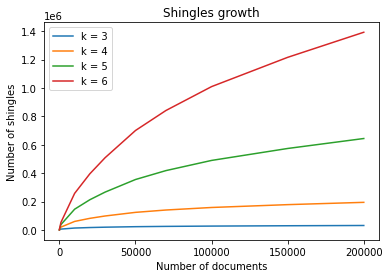

In [247]:
for k in [4, 5, 6]:
    plt.plot(
        results[k]['docs'], 
        results[k]['shingles'],
        label=f'k = {k}'
    )
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of shingles')
plt.title('Shingles growth')
plt.legend(loc='best')
plt.savefig('img/shingles_growth.png', dpi=300)

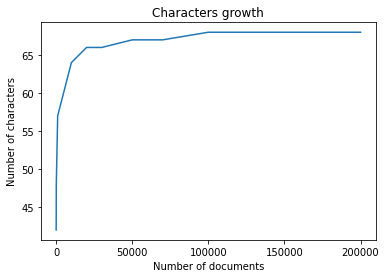

In [248]:
plt.plot(
    results[5]['docs'], 
    results[5]['characters']
)
plt.xticks([0, 50000, 100000, 150000, 200000])
plt.xlabel('Number of documents')
plt.ylabel('Number of characters')
plt.title('Characters growth')
plt.savefig('img/char_growth.png', dpi=300)

## Number of hash bits

In [275]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for n_bits in [12, 14, 16, 18, 19, 20, 22]:
        ckpt_path = f'checkpoints/k{k}_n_bits{n_bits}'
        time_path = f'{ckpt_path}/time.npy'

        model = LSHModel(
            k=k,
            threshold=0.1,
            num_hashes=100,
            shingle_hash_bits=n_bits,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()

            time_delta = np.load(
                f'{ckpt_path}/time.npy', 
                allow_pickle=True
            )

            sig_tp = dict(model.get_similar_pairs())
            
        else:
            start_time = timeit.default_timer()

            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()

            sig_tp = dict(model.get_similar_pairs())

            end_time = timeit.default_timer()
            time_delta = end_time - start_time
            np.save(f'{ckpt_path}/time.npy', time_delta)

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                n_bits, 
                time_delta,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {n_bits} bits]:\n'
            f'\t{time_delta} seconds\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} ({ratio} Prec.) (0.1 t)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Hash bits', 
            'Time delta (s)', 
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Hash bits')

[k 3, 12 bits]:
	10.873566500005836 seconds
	828 wrong out of 1988 (0.5835010060362174 Prec.) (0.1 t)
	0.027296709304486726 MAE



[k 3, 14 bits]:
	14.825079400005052 seconds
	344 wrong out of 1047 (0.6714422158548233 Prec.) (0.1 t)
	0.019095968405134466 MAE



[k 3, 16 bits]:
	32.19386189999932 seconds
	555 wrong out of 1358 (0.5913107511045655 Prec.) (0.1 t)
	0.02161256677766821 MAE



[k 3, 18 bits]:
	109.58982149999792 seconds
	389 wrong out of 1059 (0.6326723323890463 Prec.) (0.1 t)
	0.019830625756691485 MAE



[k 3, 19 bits]:
	199.52453850000165 seconds
	861 wrong out of 1650 (0.4781818181818182 Prec.) (0.1 t)
	0.03115090980550743 MAE



[k 3, 20 bits]:
	394.60135539999465 seconds
	547 wrong out of 1235 (0.557085020242915 Prec.) (0.1 t)
	0.021456358052244377 MAE



[k 3, 22 bits]:
	1552.1595470999964 seconds
	653 wrong out of 1346 (0.5148588410104011 Prec.) (0.1 t)
	0.025835155729074844 MAE



[k 4, 12 bits]:
	13.415311700002349 seconds
	317 wrong out of 491 (0.3543788187372709 Prec.) (0.1 t)
	0.02336637226431859 MAE



[k 4, 14 bits]:
	15.635955099998682 seconds
	210 wrong out of 326 (0.3558282208588957 Prec.) (0.1 t)
	0.02212482070200454 MAE



[k 4, 16 bits]:
	33.96939469999779 seconds
	183 wrong out of 287 (0.3623693379790941 Prec.) (0.1 t)
	0.02317018446897908 MAE



[k 4, 18 bits]:
	105.85842709999997 seconds
	152 wrong out of 258 (0.4108527131782946 Prec.) (0.1 t)
	0.028766453888946233 MAE



[k 4, 19 bits]:
	197.83542330000637 seconds
	64 wrong out of 146 (0.5616438356164384 Prec.) (0.1 t)
	0.017888358192926054 MAE



KeyboardInterrupt: 

In [39]:
for k in [3, 4, 5]:
    print(results[k].round(3)) 

           Time delta (s)  Predicted pairs  Wrong pairs  Wrong ratio    MAE
Hash bits                                                                  
16                 31.111              334          210        0.629  0.018
18                100.373              177           69        0.390  0.015
19                194.698              435          310        0.713  0.028
20                373.534              234          125        0.534  0.020
22               1412.158              185           92        0.497  0.018
           Time delta (s)  Predicted pairs  Wrong pairs  Wrong ratio    MAE
Hash bits                                                                  
16                 30.373               83           35        0.422  0.014
18                 97.623              246          187        0.760  0.027
19                184.124              110           60        0.545  0.014
20                354.228              112           65        0.580  0.013
22          

## Threshold choice

In [ ]:
results = dict()

for k in [3, 4, 5]:
    ls = []

    for t in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]:
        ckpt_path = f'checkpoints/k{k}_t{t}'

        model = LSHModel(
            k=k,
            threshold=t,
            num_hashes=100,
            shingle_hash_bits=16,
            track_shingles=True,
            checkpoint_path=ckpt_path
        )

        if os.path.isdir(ckpt_path) and \
            len(os.listdir(ckpt_path)) > 0:
            model.load_checkpoint()
            sig_tp = dict(model.get_similar_pairs())
            
        else:
            model = train_model(
                model=model, 
                data_path=DATA_PATH,
                num_docs=100,
                verbose=False,
                filtering_pipeline=filtering_pipeline,
                preprocessing_pipeline=preprocessing_pipeline,
            )
            model.save_checkpoint()
            sig_tp = dict(model.get_similar_pairs())

        cm_tp, _ = model.check_threshold_on_cm()
        cm_tp = dict(cm_tp)
        num_wrong, mae = evaluate_on_cm(sig_tp, cm_tp)
        correct = len(sig_tp) - num_wrong
        ratio = correct / len(sig_tp)

        ls.append(
            (
                t,
                len(sig_tp),
                correct, 
                num_wrong,
                ratio,
                mae
            )
        )

        print(
            f'[k {k}, {t} threshold]:\n'
            f'\t{num_wrong} wrong out of {len(sig_tp)} \
                ({ratio} Prec.) (0.1 t)\n'
            f'\t{mae} MAE\n'
        )
    
    results[k] = pd.DataFrame(
        ls,
        columns=[
            'Threshold', 
            'Predicted pairs',
            'Correct pairs (TP)', 
            'Wrong pairs (FP)', 
            'Correct ratio (Prec.)',
            'MAE'
        ]
    ).set_index('Threshold')

## 500k Tweets comparison

### Train LSH model

MORE THAN ONE MODEL?

In [274]:
ckpt_path = f'checkpoints/test/test1'
model = LSHModel(
    k=5,
    threshold=0.1,
    num_hashes=100,
    shingle_hash_bits=16,
    track_shingles=True,
    checkpoint_path=ckpt_path
)
model = train_model(
    model=model, 
    data_path=DATA_PATH,
    num_docs=100,
    verbose=True,
    filtering_pipeline=filtering_pipeline,
    preprocessing_pipeline=preprocessing_pipeline,
)

Adding documents to model:   0%|          | 0/100 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip


Found 191292 duplicates in files


In [165]:
ckpt_path = f'checkpoints/d100/k5_t0.1_bits16'
model = LSHModel(
    k=5,
    threshold=0.1,
    num_hashes=100,
    shingle_hash_bits=16,
    track_shingles=True,
    checkpoint_path=ckpt_path
)
model = train_model(
    model=model, 
    data_path=DATA_PATH,
    num_docs=100,
    verbose=True,
    preprocessing_pipeline=preprocessing_pipeline,
)

Adding documents to model:   0%|          | 0/100 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip


Found 191292 duplicates in files


In [166]:
similar_pairs = model.get_similar_pairs()

Loaded signature from row 65535


### MPNet embeddings

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
)
mpnet = AutoModel.from_pretrained(
    'sentence-transformers/all-mpnet-base-v2'
).to(device)

In [ ]:
mpnet_preprocessing = [
    replace_chars,
    str.lower,
    normalize_white_space
]

In [168]:
idx_ls = np.unique(
    np.array(
        [
            list(pair)
            for pair, _ in similar_pairs
        ] 
    ).flatten()
)
text_dict = dict(get_text(idx_ls, DATA_PATH))

preprocessed_texts = []
for text in text_dict.values():
    for f in mpnet_preprocessing:
        text = f(text)
    preprocessed_texts.append(text)

encoded_input = tokenizer(
    preprocessed_texts, 
    padding='max_length', 
    truncation=True, 
    return_tensors='pt'
).to(device)

array([ 0,  1,  2,  4,  6,  9, 10, 12, 13, 14, 15, 16, 19, 20, 21, 23, 25,
       27, 28, 30, 31, 32, 35, 36, 37, 38, 39, 41, 43, 44, 45, 47, 49, 50,
       51, 52, 53, 57, 58, 63, 64, 66, 67, 69, 70, 71, 73, 75, 76, 77, 78,
       79, 86, 87, 89, 91, 92, 96, 97, 98])

In [236]:
with torch.no_grad():
    model_output = model(**encoded_input)

embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

embeddings_dict = {
    key: val
    for key, val in zip(text_dict.keys(), embeddings)
}

In [237]:
lsh_sims = []
mpnet_sims = []

for ((x_idx, y_idx), lsh_sim) in similar_pairs:
    lsh_sims.append(lsh_sim)
    mpnet_sims.append(
        torch_cosine_similarity(
            embeddings_dict[x_idx],
            embeddings_dict[y_idx],
        )
    )

### Compare rankings

In [239]:
kendalltau(lsh_sims, mpnet_sims)

KendalltauResult(correlation=0.4790651278562069, pvalue=9.727797364038488e-09)

In [241]:
spearmanr(lsh_sims, mpnet_sims)

SpearmanrResult(correlation=0.6255073800230813, pvalue=1.1872875150277376e-09)

In [269]:
ckpt_path = f'checkpoints/test/test1'
model = LSHModel(
    k=5,
    threshold=0.1,
    num_hashes=100,
    shingle_hash_bits=16,
    track_shingles=True,
    checkpoint_path=ckpt_path
)

num_docs = 100

files = []
data_path = DATA_PATH

for name in os.listdir(data_path):
    full_path = os.path.join(data_path, name)
    if os.path.isfile(full_path):
        files.append(full_path)

duplicates = 0
count = num_docs

with tqdm(
    total=num_docs,
    desc='Adding documents to model',
    leave=False
) as pbar:
    for file in files:
        if count == 0:
            break
        
        print(f'Reading file {file}')
        df = pd.read_csv(
            file, 
            compression='gzip', 
            index_col=0,
            encoding='utf-8', 
            quoting=csv.QUOTE_ALL,
            low_memory=False
        )

        df = df[df['language'] == 'en']

        for filter_f in filtering_pipeline:
            df['text'] = df['text'].apply(filter_f)

        df_unique = df.drop_duplicates(subset=['text'])
        duplicates += len(df) - len(df_unique)

Adding documents to model:   0%|          | 0/100 [00:00<?, ?it/s]

Reading file e:\datasets\ukraine\0401_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0402_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0403_UkraineCombinedTweetsDeduped.csv.gzip
Reading file e:\datasets\ukraine\0404_UkraineCombinedTweetsDeduped.csv.gzip


KeyboardInterrupt: 

In [256]:
# List of Tuples
matrix = [('22', '34', '23'),
         ('33', '31', '11'),
         ('44', '16', '21'),
         ('55', '32', '22'),
         ('66', '33', '27'),
         ('77', '35', '11')
         ]
# Create a DataFrame object
dfObj = pd.DataFrame(matrix, columns=list('xyz'), index=list('abcdef'))

In [257]:
dfObj

,x,y,z
a,22,34,23
b,33,31,11
c,44,16,21
d,55,32,22
e,66,33,27
f,77,35,11


In [268]:
dfObj['z'] = dfObj['z'].apply(remove_https)
dfObj

,x,y,z
a,22,34,23
b,33,31,11
c,44,16,21
d,55,32,22
e,66,33,27
f,77,35,11


In [267]:
remove_https('ababss')

'ababss'